# The code
This code takes the smoothed nii file of eyes(we are planning to work with a whole brain), then it puts a mask on it and calculates the center of the mass and show it in a 3D plot in time

## Importing libraries

- nibabel - reading/writing NIIFTI files
- numpy - arrays
- maxflow - graph cuts for segmnmentation
- matplotlib - visualision 
- scipy ndimage - morphological operations and image processing
- skimage - atomatic tresholding
- pandas - csv files of center of mass

In [22]:
import nibabel as nib
import numpy as np
import maxflow
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy import ndimage
from skimage.filters import threshold_otsu
import pandas as pd
from skimage import measure
import plotly.graph_objects as go

## Putting the binary mask on a file
1) Taking the data
2) Initializing the eye_mask(4D) and mask_3d so they will have the same size as our data
3) Normalizing - we are rescaling data to be in range [0,1] it ensuers that all silces are on the same scale comparision and works the best with maxflow and otsu
4) Graph construction - each pixel in the image becomes a node, we have two nodes(S - foregrounf, T- background), there is also the weight which define how strong the pixel belongs to S or T
5) Otsu method dind the foreground and background seeds
6) Adding terminal Edges
7) Adding Neighbour Edges, sigma controls sensitivity
8) Ectracting segmentation mask (true foreground, false background)
9) Post processing - dilates the mask to fill small holes
10) Visualization and saving the results

For the future: we can try and make the algorithms more precise (tresholds, weights, sigma, iterration) and make the mask smoother, I want it also to work with the whole brain image. Making algorithm faster using multiprocessing?????

Image shape: (49, 58, 49, 128)

Processing time point 1/128...

Processing time point 2/128...

Processing time point 3/128...

Processing time point 4/128...

Processing time point 5/128...

Processing time point 6/128...

Processing time point 7/128...

Processing time point 8/128...

Processing time point 9/128...

Processing time point 10/128...

Processing time point 11/128...

Processing time point 12/128...

Processing time point 13/128...

Processing time point 14/128...

Processing time point 15/128...

Processing time point 16/128...

Processing time point 17/128...

Processing time point 18/128...

Processing time point 19/128...

Processing time point 20/128...

Processing time point 21/128...

Processing time point 22/128...

Processing time point 23/128...

Processing time point 24/128...

Processing time point 25/128...

Processing time point 26/128...

Processing time point 27/128...

Processing time point 28/128...

Processing time point 29/128...

Processing time poin

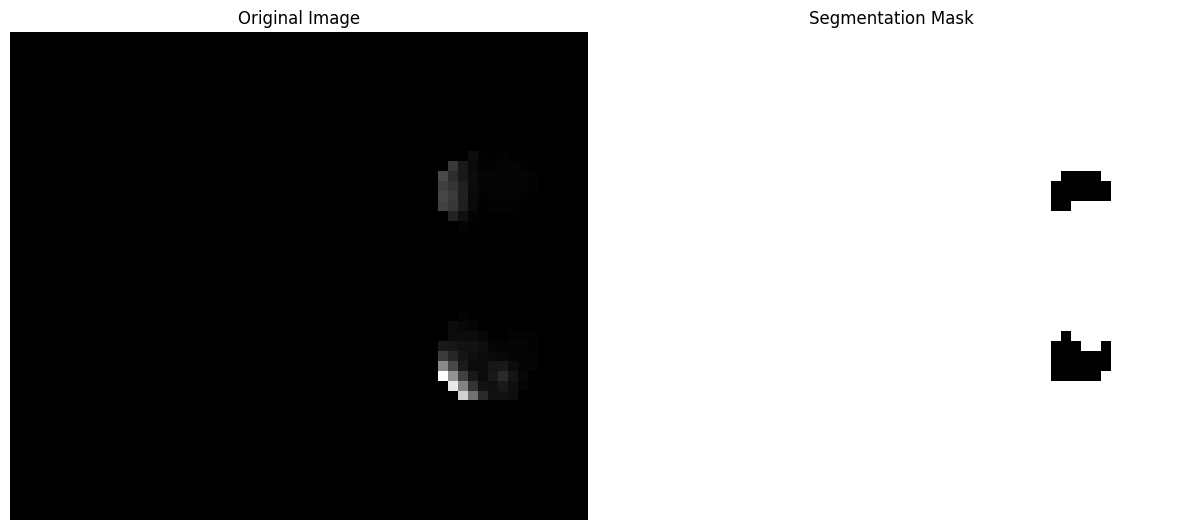

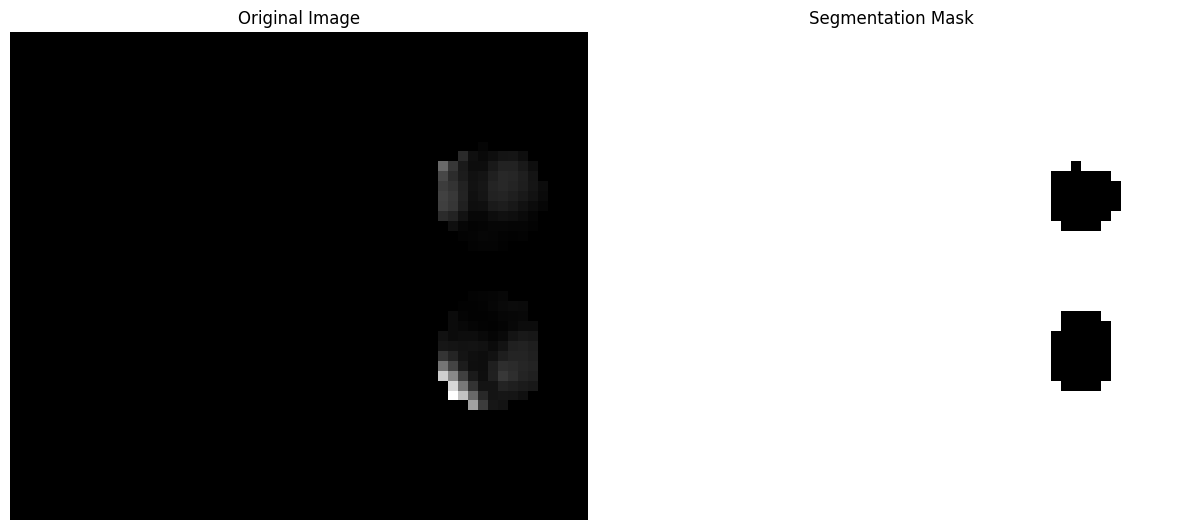

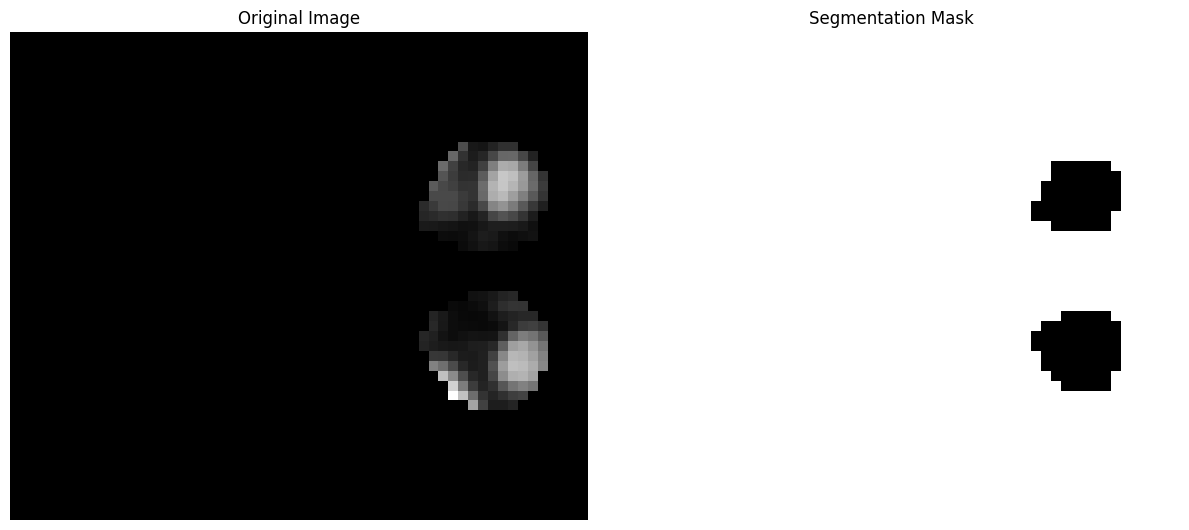

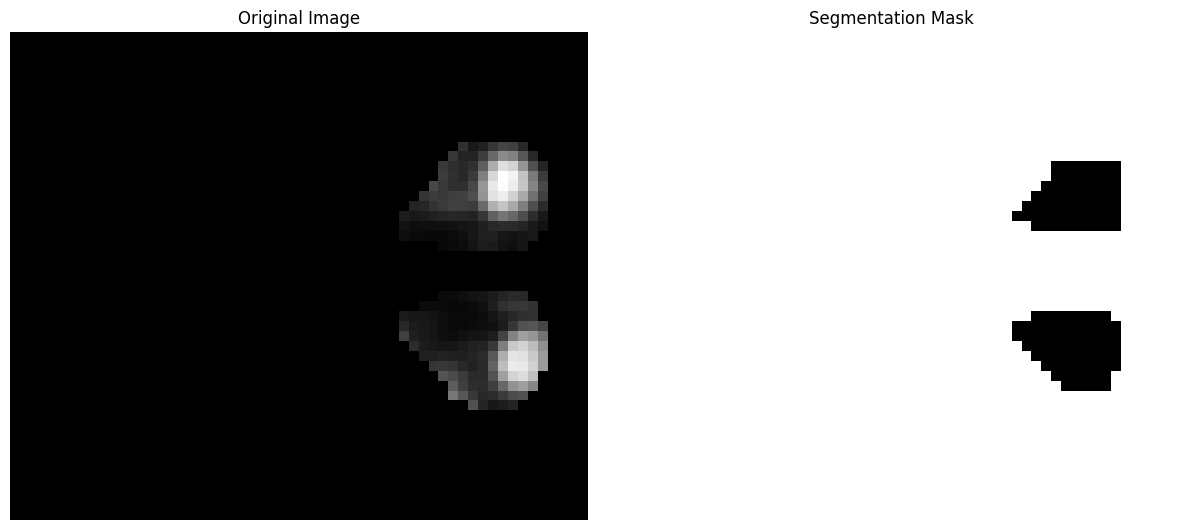

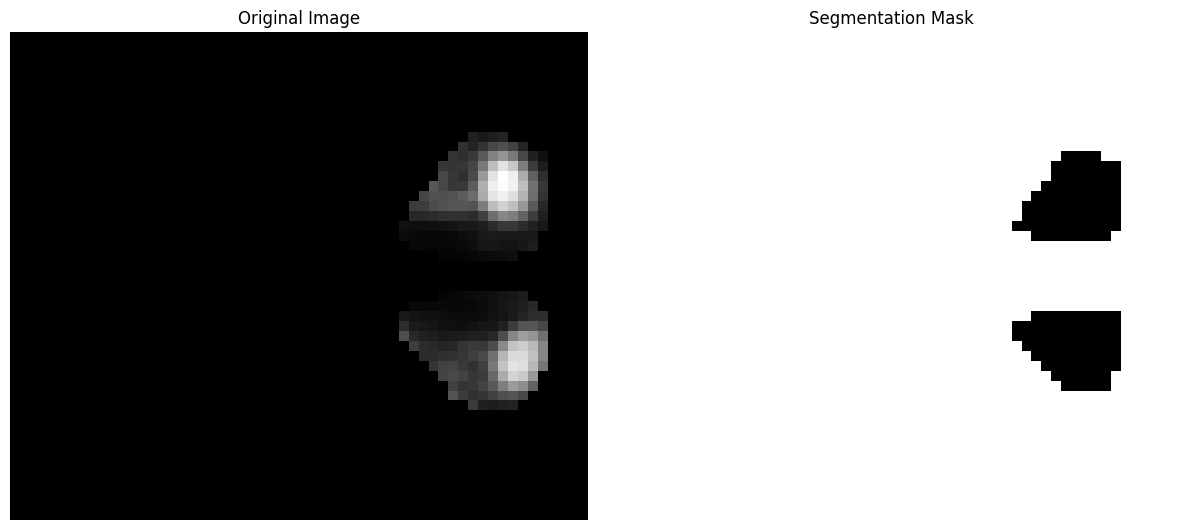

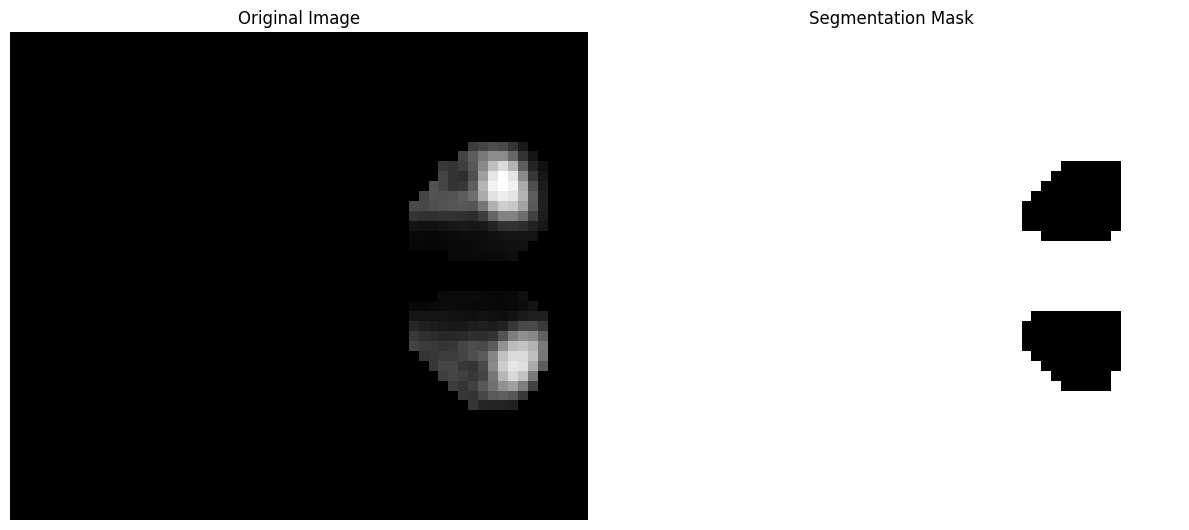

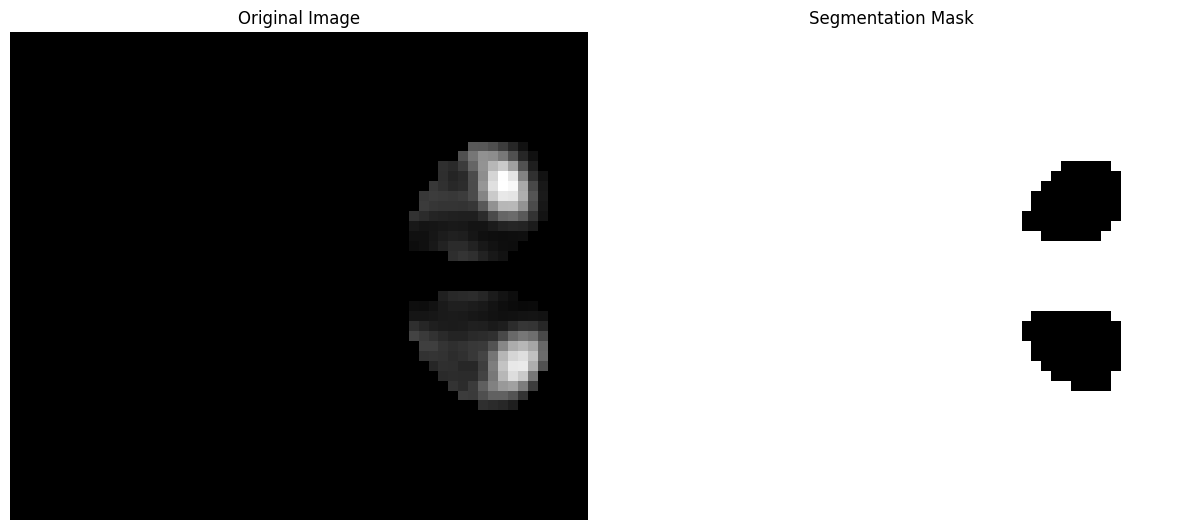

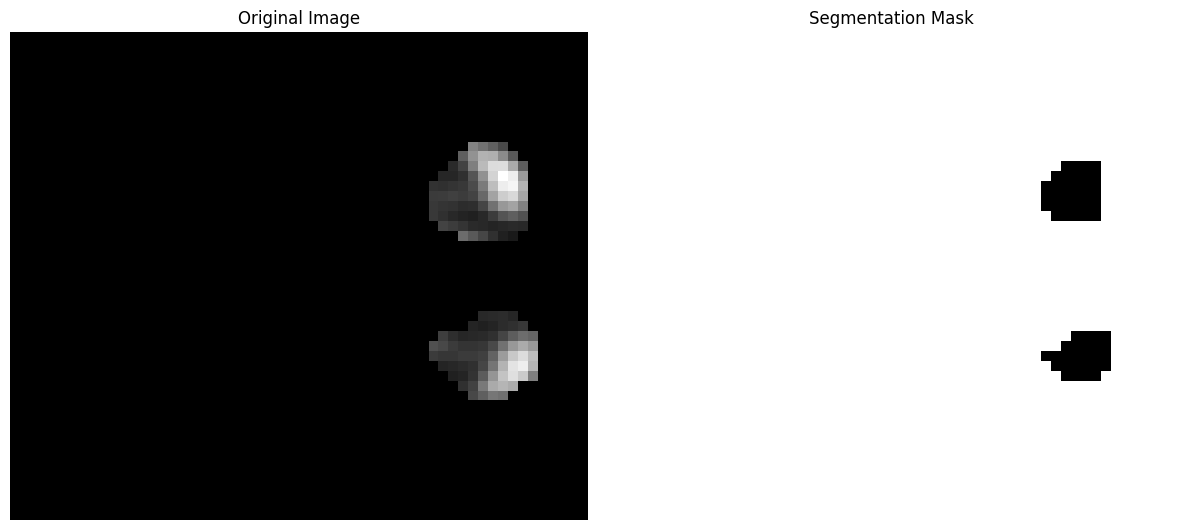


Eye segmentation completed and saved as 'eye_mask.nii'.


In [23]:
# Load the 4D NIfTI image
nii_file = 'smoothed_masked.nii'
img = nib.load(nii_file)
data = img.get_fdata()
print(f"Image shape: {data.shape}")

# Initialize mask
eye_mask = np.zeros_like(data, dtype=np.uint8)

for t in range(data.shape[3]): 
    print(f"\nProcessing time point {t+1}/{data.shape[3]}...")
    mask_3d = np.zeros(data.shape[:3], dtype=np.uint8)

    for z in range(data.shape[2]):  # Process only relevant slices
        image = data[:, :, z, t]
        
        # Normalization
        min_val, max_val = np.min(image), np.max(image)
        if max_val > min_val:
            image_norm = (image - min_val) / (max_val - min_val)
        else:
            image_norm = np.zeros_like(image)
        
        # Create graph
        g = maxflow.Graph[float]()
        nodeids = g.add_nodes(image.size)
        nodeids = nodeids.reshape(image.shape)
        
        # Automatic seed definition using Otsu's thresholding
        try:
            thresh = threshold_otsu(image_norm[image_norm > 0])
            foreground_seed = (image_norm >= 0.02*thresh).astype(bool)
            background_seed = (image_norm < 0.1*thresh).astype(bool)
        except:
            # Fallback if Otsu fails
            foreground_seed = (image_norm >= 0.5).astype(bool)
            background_seed = (image_norm < 0.1).astype(bool)
        
        # Add terminal edges (t-links)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if foreground_seed[i,j]:
                    g.add_tedge(nodeids[i,j], 100, 0)  # Strong connection to source
                elif background_seed[i,j]:
                    g.add_tedge(nodeids[i,j], 0, 100)   # Strong connection to sink
                else:
                    # Unseeded pixels with data term based on intensity
                    g.add_tedge(nodeids[i,j], 
                               image_norm[i,j],  # cost to source
                               1 - image_norm[i,j])  # cost to sink
        
        # Add n-links (neighborhood edges) with exponential weighting
        sigma = 0.6  # controls edge sensitivity to intensity differences
        for i in range(image.shape[0]-1):
            for j in range(image.shape[1]-1):
                # Horizontal edges
                weight = np.exp(-(image_norm[i,j] - image_norm[i,j+1])**2 / sigma**2)
                g.add_edge(nodeids[i,j], nodeids[i,j+1], weight, weight)
                
                # Vertical edges
                weight = np.exp(-(image_norm[i,j] - image_norm[i+1,j])**2 / sigma**2)
                g.add_edge(nodeids[i,j], nodeids[i+1,j], weight, weight)
        
        # Solve maxflow/mincut
        g.maxflow()
        
        # Get segmentation
        segmented_mask = np.zeros_like(image_norm, dtype=bool)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                segmented_mask[i,j] = g.get_segment(nodeids[i,j])
        
        # Post-processing
        mask_3d[:,:,z] = binary_dilation(segmented_mask, iterations=2)
    
    # Invert the binary mask
    eye_mask[:,:,:,t] = 1 - mask_3d
    
for z in range(6,14):
    plt.figure(figsize=(12, 6))

# Original image
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, z, t], cmap='gray')  # Showing slice z=10 as example
    plt.title("Original Image")
    plt.axis('off')

# Mask only
    plt.subplot(1, 2, 2)
    plt.imshow(eye_mask[:, :, z, t], cmap='binary')  # Binary colormap for clean mask
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
        
# Save the final 4D segmented mask
masked_nii = nib.Nifti1Image(eye_mask, img.affine)
nib.save(masked_nii, "eye_mask.nii")
print("\nEye segmentation completed and saved as 'eye_mask.nii'.")

### Comparision of the mask and the data

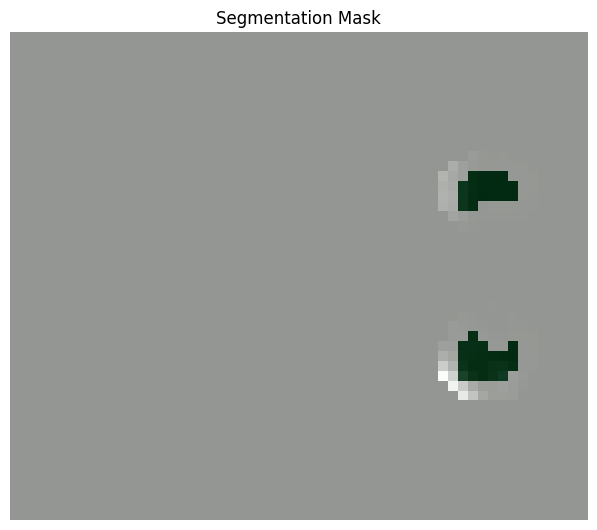

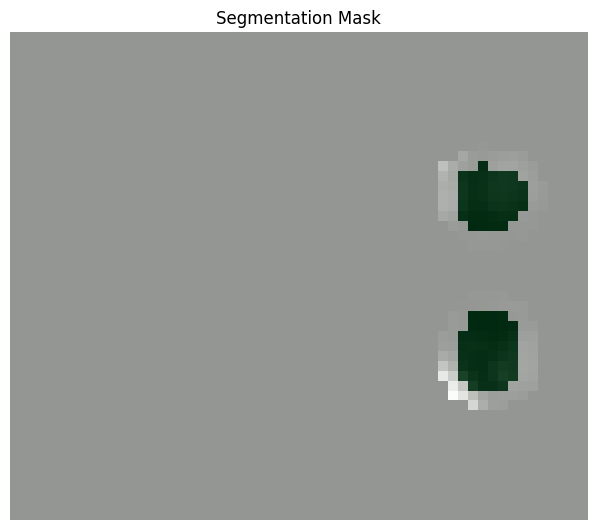

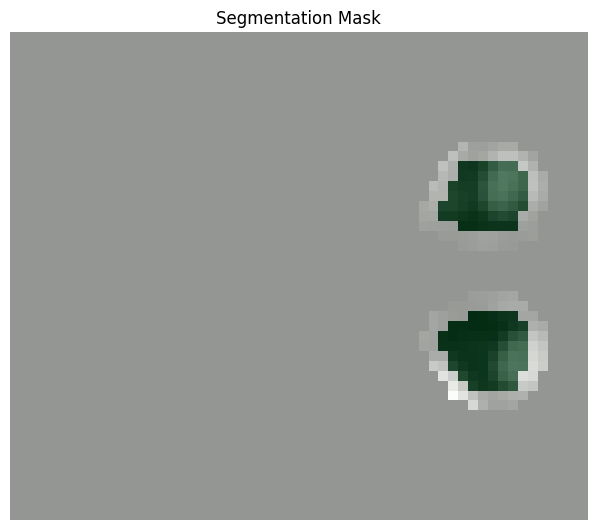

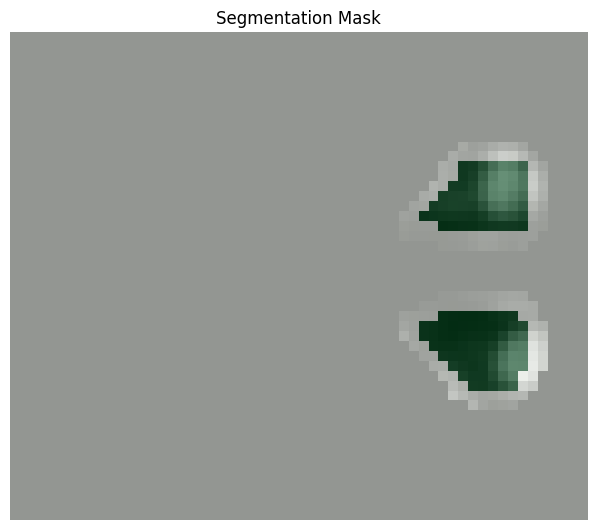

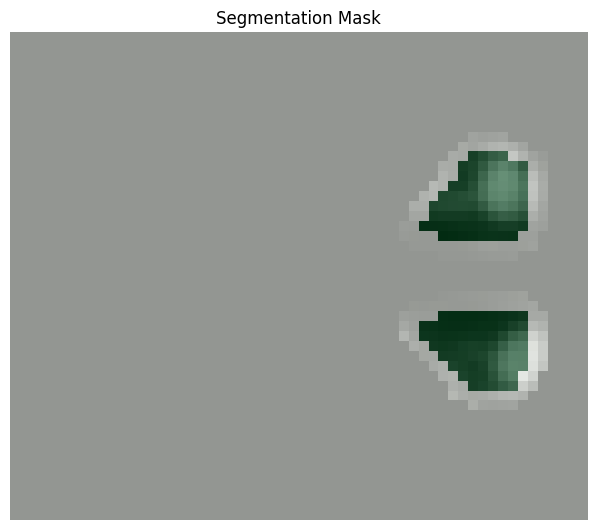

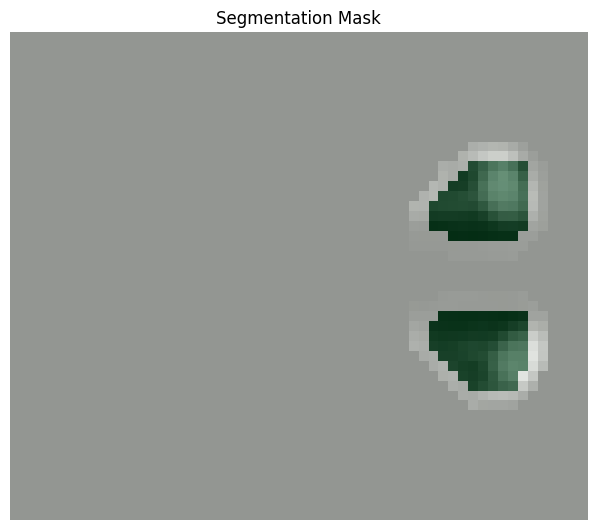

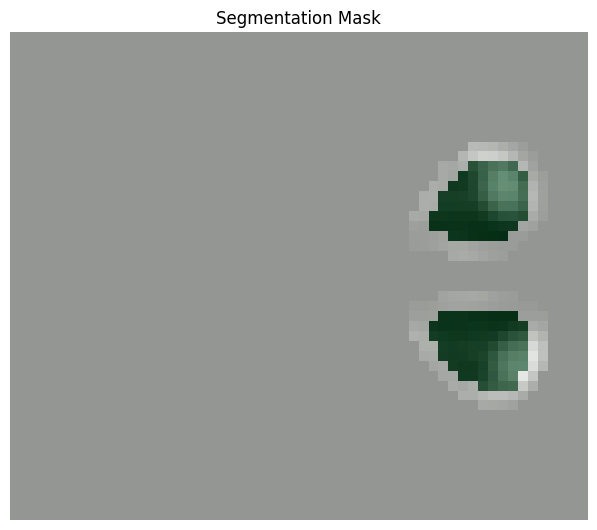

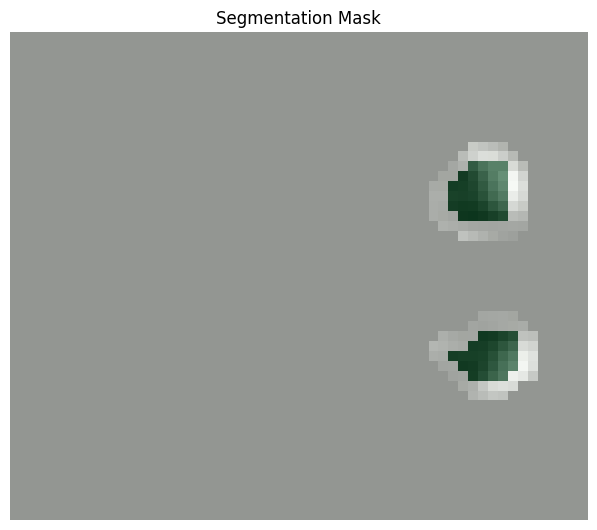

In [24]:
for z in range(6,14):
    plt.figure(figsize=(12, 6))

# Original image
    plt.subplot(1, 2, 1)
    plt.imshow(data[:, :, z, t], cmap='gray')  # Showing slice z=10 as example
    plt.title("Original Image")
    plt.axis('off')

# Mask only
    #plt.subplot(1, 2, 2)
    plt.imshow(eye_mask[:, :, z, t], cmap='Greens', alpha=0.6)  # Binary colormap for clean mask
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## Calculating the center of mass
1) loading the nifti file of a masked eye
2) vaklidation of dimensions
3) deviding data to the middle point of X-axis so we can devide it into left and right eye
4) spliting into left and right halves
5)  ndimage.center_of_mass calsulates the center of mass (x,y,z) of left and right eye
6) Adjusting the right eye movement - we are changing the paramateres of X during the eye devision so we have to ensure that everything is calculate corectly
7) saving the results


In [25]:
def centres_of_masses_3d_volume(volume, mid_x=None):
    """Calculate 3D centers of mass for left and right eyes from a 3D volume"""
    if mid_x is None:
        mid_x = volume.shape[0] // 2
    
    # Split into left and right halves
    left_mask = volume[:mid_x, :, :]
    right_mask = volume[mid_x:, :, :]
    
    # Calculate centers of mass
    left_com = ndimage.center_of_mass(left_mask)
    right_com = ndimage.center_of_mass(right_mask)
    
    # Adjust right eye X coordinate
    right_com = (right_com[0] + mid_x, right_com[1], right_com[2])
    
    return {
        "Left Eye": left_com,
        "Right Eye": right_com
    }

def centres_of_masses_4d(file):
    """Calculate 3D centers of mass for left and right eyes from a 4D NIfTI file across time"""
    # Load NIfTI file
    img = nib.load(file)
    masks = img.get_fdata()
    
    # Check if the image is 4D
    if len(masks.shape) != 4:
        raise ValueError("Input file must be a 4D NIfTI (3D + time)")
    
    num_timepoints = masks.shape[3]
    mid_x = masks.shape[0] // 2
    
    # Prepare results storage
    all_com = []
    
    for t in range(num_timepoints):
        # Get volume for current timepoint
        volume = masks[..., t]
        
        # Calculate centers of mass for this volume
        com_3d = centres_of_masses_3d_volume(volume, mid_x)
        all_com.append(com_3d)
    
    # Save to CSV
    data = []
    for t in range(num_timepoints):
        data.append({
            "Timepoint": t,
            "Left_X": all_com[t]["Left Eye"][0],
            "Left_Y": all_com[t]["Left Eye"][1],
            "Left_Z": all_com[t]["Left Eye"][2],
            "Right_X": all_com[t]["Right Eye"][0],
            "Right_Y": all_com[t]["Right Eye"][1],
            "Right_Z": all_com[t]["Right Eye"][2]
        })
    
    df = pd.DataFrame(data)
    df.to_csv("centers_of_masses_4d.csv", index=False)
    
    return all_com, masks

# Print results for first and last timepoints
print(f"4D Centers of Mass ({com_4d['Timepoints']} timepoints)")
print("\nFirst timepoint:")
print(f"Left Eye:  X = {com_4d['Left Eye'][0][0]:.2f}, Y = {com_4d['Left Eye'][0][1]:.2f}, Z = {com_4d['Left Eye'][0][2]:.2f}")
print(f"Right Eye: X = {com_4d['Right Eye'][0][0]:.2f}, Y = {com_4d['Right Eye'][0][1]:.2f}, Z = {com_4d['Right Eye'][0][2]:.2f}")

print("\nLast timepoint:")
print(f"Left Eye:  X = {com_4d['Left Eye'][-1][0]:.2f}, Y = {com_4d['Left Eye'][-1][1]:.2f}, Z = {com_4d['Left Eye'][-1][2]:.2f}")
print(f"Right Eye: X = {com_4d['Right Eye'][-1][0]:.2f}, Y = {com_4d['Right Eye'][-1][1]:.2f}, Z = {com_4d['Right Eye'][-1][2]:.2f}")

4D Centers of Mass (128 timepoints)

First timepoint:
Left Eye:  X = 16.32, Y = 47.11, Z = 9.85
Right Eye: X = 31.34, Y = 47.08, Z = 9.76

Last timepoint:
Left Eye:  X = 16.32, Y = 47.11, Z = 9.85
Right Eye: X = 31.30, Y = 47.08, Z = 9.69


## 4D image

### Creating 3D image
1) taking the nifti file and comupting the COMs of left and right eye
2) creating an empty Ploty figure
3) adding the firs frame with time = 0 to the figure with 3D mesh and COMs
4) iterating trought time points
5) Adding play/pause buttons

In [26]:
def create_animated_3d_plot(nifti_file, output_html="animated_eye_mask.html"):
    """Create an animated 3D plot showing eye masks and centers of mass over time"""
    # Calculate centers of mass for all timepoints
    all_com, masks = centres_of_masses_4d(nifti_file)
    num_timepoints = masks.shape[3]
    
    # Create figure
    fig = go.Figure()
    
    # Add initial frame (time point 0)
    add_frame_to_animation(fig, masks[..., 0], all_com[0], 0)
    
    # Create frames for all time points
    frames = []
    for t in range(num_timepoints):
        frame = create_animation_frame(masks[..., t], all_com[t], t)
        frames.append(frame)
    
    # Add animation controls
    fig.frames = frames
    fig.update_layout(
        updatemenus=[{
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": True},
                                  "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                     "mode": "immediate",
                                     "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }],
        sliders=[{
            "active": 0,
            "yanchor": "top",
            "xanchor": "left",
            "currentvalue": {
                "font": {"size": 20},
                "prefix": "Time point:",
                "visible": True,
                "xanchor": "right"
            },
            "transition": {"duration": 300, "easing": "cubic-in-out"},
            "pad": {"b": 10, "t": 50},
            "len": 0.9,
            "x": 0.1,
            "y": 0,
            "steps": [{
                "args": [[f.name], {"frame": {"duration": 300, "redraw": True},
                                    "mode": "immediate",
                                    "transition": {"duration": 0}}],
                "label": str(k),
                "method": "animate"
            } for k, f in enumerate(fig.frames)]
        }]
    )
    
    # Adjust layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', showbackground=False),
            yaxis=dict(title='Y', showbackground=False),
            zaxis=dict(title='Z', showbackground=False),
            aspectmode='data'
        ),
        margin=dict(r=20, l=10, b=10, t=50),
        title="Animated 3D Eye Mask with Centers of Mass"
    )
    
    fig.show()
    fig.write_html(output_html)
    return fig

In [29]:


def add_frame_to_animation(fig, volume, com_3d, time_point):
    """Add a single frame to the animation figure"""
    # Create mesh for this time point
    verts, faces = create_mesh(volume)
    
    if verts is not None:
        # Add the eye mask mesh
        fig.add_trace(go.Mesh3d(
            x=verts[:, 0],
            y=verts[:, 1],
            z=verts[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            opacity=0.4,
            color='#DC143C',
            flatshading=True,
            showscale=False,
            name=f"Eye Mask (t={time_point})"
        ))
    
    # Add centers of mass
    if com_3d:
        # Left eye (red)
        fig.add_trace(go.Scatter3d(
            x=[com_3d["Left Eye"][0]],
            y=[com_3d["Left Eye"][1]],
            z=[com_3d["Left Eye"][2]],
            mode='markers',
            marker=dict(size=10, color='green'),
            name=f"Left COM (t={time_point})"
        ))
        
        # Right eye (blue)
        fig.add_trace(go.Scatter3d(
            x=[com_3d["Right Eye"][0]],
            y=[com_3d["Right Eye"][1]],
            z=[com_3d["Right Eye"][2]],
            mode='markers',
            marker=dict(size=10, color='blue'),
            name=f"Right COM (t={time_point})"
        ))

def create_animation_frame(volume, com_3d, time_point):
    """Create a single animation frame for a specific time point"""
    traces = []
    
    # Create mesh for this time point
    verts, faces = create_mesh(volume)
    
    if verts is not None:
        # Add the eye mask mesh
        traces.append(go.Mesh3d(
            x=verts[:, 0],
            y=verts[:, 1],
            z=verts[:, 2],
            i=faces[:, 0],
            j=faces[:, 1],
            k=faces[:, 2],
            opacity=0.6,
            color='#DC143C',
            flatshading=True,
            showscale=False,
            name=f"Eye Mask (t={time_point})"
        ))
    
    # Add centers of mass
    if com_3d:
        # Left eye (red)
        traces.append(go.Scatter3d(
            x=[com_3d["Left Eye"][0]],
            y=[com_3d["Left Eye"][1]],
            z=[com_3d["Left Eye"][2]],
            mode='markers',
            marker=dict(size=10, color='green'),
            name=f"Left COM (t={time_point})"
        ))
        
        # Right eye (blue)
        traces.append(go.Scatter3d(
            x=[com_3d["Right Eye"][0]],
            y=[com_3d["Right Eye"][1]],
            z=[com_3d["Right Eye"][2]],
            mode='markers',
            marker=dict(size=10, color='blue'),
            name=f"Right COM (t={time_point})"
        ))
    
    return go.Frame(data=traces, name=str(time_point))

def create_mesh(volume):
    """Create mesh from 3D volume using marching cubes"""
    if volume.dtype != bool:
        volume = volume > 0.5
    
    padded_volume = np.pad(volume, pad_width=1, mode='constant', constant_values=0)
    
    try:
        verts, faces, _, _ = measure.marching_cubes(
            padded_volume,
            level=0.5,
            step_size=1,
            allow_degenerate=False
        )
        verts = verts - 1  # Remove padding offset
        return verts, faces
    except Exception as e:
        print(f"Error generating mesh: {str(e)}")
        return None, None

# Example usage
file_path = 'eye_mask.nii'

# Calculate and save centers of mass
all_com, masks = centres_of_masses_4d(file_path)

# Create animated plot
create_animated_3d_plot(file_path)

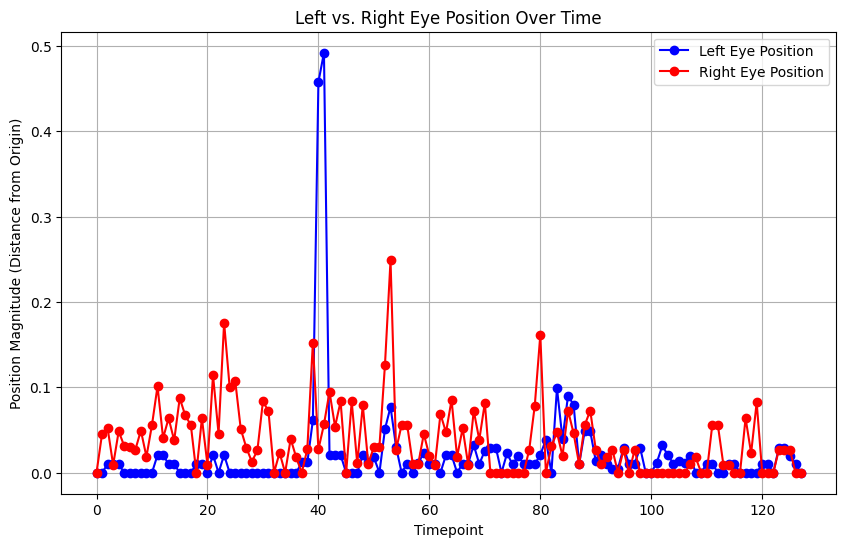

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data (replace with your file)
df = pd.read_csv('centers_of_masses_4d.csv')
# Compute differences between consecutive rows for the left eye's coordinates
df['X_diff_left'] = df['Left_X'].diff().fillna(0)
df['Y_diff_left'] = df['Left_Y'].diff().fillna(0)
df['Z_diff_left'] = df['Left_Z'].diff().fillna(0)

df['X_diff_right'] = df['Right_X'].diff().fillna(0)
df['Y_diff_right'] = df['Right_Y'].diff().fillna(0)
df['Z_diff_right'] = df['Right_Z'].diff().fillna(0)

# Compute the magnitude (distance from origin) for the left eye
df['Left_Position'] = np.sqrt(df['X_diff_left']**2 + df['Y_diff_left']**2 + df['Z_diff_left']**2)
df['Right_Position'] = np.sqrt(df['X_diff_right']**2 + df['Y_diff_right']**2 + df['Z_diff_right']**2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Timepoint'], df['Left_Position'], label='Left Eye Position', color='blue', marker='o')
plt.plot(df['Timepoint'], df['Right_Position'], label='Right Eye Position', color='red', marker='o')
plt.xlabel('Timepoint')
plt.ylabel('Position Magnitude (Distance from Origin)')
plt.title('Left vs. Right Eye Position Over Time')
plt.legend()
plt.grid(True)
plt.show()